In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, learning_curve
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Первым делом надо подключить библиотеку и провизуализировать данные

1. Сейчас надо понять где пропуски и что с ними делать.
2. Надо понять какие признаки категории, а какие непрерывные.
После этого надо понять как преобразовать категории

In [3]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [4]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [5]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

В этом месте хочу понять как преобразовать категории в бинарные значения чтобы с ними
адекватно потом работать

In [7]:
#По этому признаку я понимаю что есть 4 значения, причем Home Mortgage и Have Mortgage
#по факту одно и то же и это одна категория.
#Соответственно всего 3 категории (Аренда, Ипотека, свое жилье)
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

In [8]:
df_train['Years in current job'].value_counts()


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [9]:
df_train['Tax Liens'].value_counts()



0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

In [10]:
df_train['Number of Open Accounts'].value_counts()



9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      2
37.0      2
42.0      1
43.0      1
35.0      1
38.0      1
41.0      1
Name: Number of Open Accounts, dtype: int64

In [11]:
df_train['Years of Credit History'].value_counts()



15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: Years of Credit History, Length: 408, dtype: int64

In [12]:
df_train['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
358732.0      3
323312.0      3
             ..
235642.0      1
1435456.0     1
397078.0      1
537680.0      1
1516482.0     1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [13]:
df_train['Number of Credit Problems'].value_counts()



0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

In [14]:
df_train['Months since last delinquent'].value_counts()


14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [15]:
df_train['Bankruptcies'].value_counts()



0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [16]:
df_train['Purpose'].value_counts()



debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [17]:
df_train['Purpose'].value_counts()



debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [18]:
df_train['Term'].value_counts()



Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [19]:
df_train['Monthly Debt'].value_counts().head(40)

0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
18997.0    3
11285.0    3
13162.0    3
21002.0    3
16502.0    3
22586.0    3
14848.0    3
14087.0    3
14476.0    3
10057.0    3
11183.0    3
12031.0    3
15036.0    3
12986.0    3
15744.0    3
9525.0     3
36579.0    3
22813.0    3
14482.0    3
18373.0    3
13565.0    3
11669.0    3
13632.0    3
13356.0    3
25511.0    3
14683.0    3
10719.0    3
7792.0     3
6876.0     3
12343.0    3
20466.0    3
8882.0     3
8994.0     3
16357.0    3
15749.0    3
Name: Monthly Debt, dtype: int64

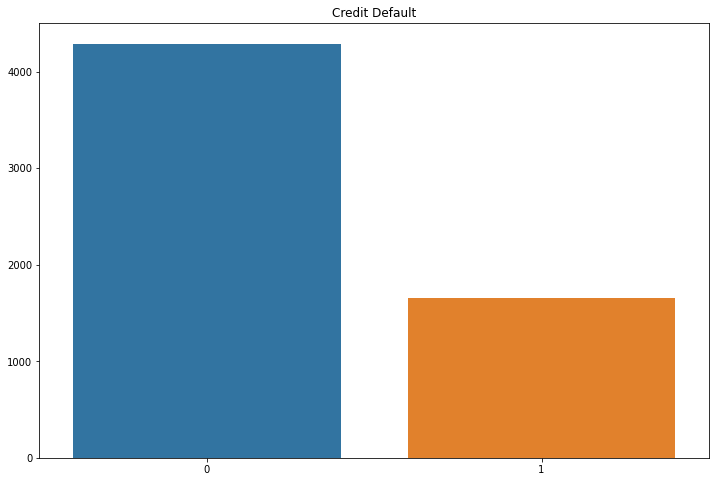

In [20]:
#Строю гистограмму всех людей у кого цель кредита консолидация долгов относительно классов кредит дефолт
#Это необходимо чтобы понять какой процент людей визульно получают одобрение кредита а какой нет при самой популярной цели кредита
def counts_bar(data_frame, feature_name):
    counts = data_frame[feature_name].value_counts()
    plt.figure(figsize=(12,8))
    plt.title(feature_name)
    sns.barplot(counts.index, counts.values)

counts_bar(df_train[df_train['Purpose'] == 'debt consolidation'], 'Credit Default')

Выводы по категориальным признакам

Home Ownership - преобразовать в 3 категории Аренда, Ипотека, свое жилье (0, 1, 2)<br/>
Years in current job - преобразовать в 4 категории менее года, от 1 до 3х включительно, от 3х до 5ти лет включительно, от 6 и выше (0, 1, 2, 3)
Все пропуски можно кидать в нулевую категорию, где менее года<br/>
Tax Liens - также категория от 4х до 7ми, самая слабая, от 1 до 3, чуть сильнее, и 0 самая сильная (0, 1, 2)<br/>
Number of Credit Problems - 4 категории по принципу как раньше от слабой к сильной,
от 4х до 7ми - 0, 2 и 3 - 1, 1 - 2 категория, 0 - 3 категория<br/>
Bankruptcies - банкротсва условно 2 категории банкрот (1) и не банкрот (0) (0, 1) банкрот это если больше нуля, остальное не банкрот<br/>
Term - Long в 1ую категорию, Short во 0ую<br/>
Purpose нужно разбить также на ранги.<br/>
1ый - все что связано с физ лицом и машиной жильем и медециной<br/>
2 - все что связано с бизнесом<br/>
3 - консолидация долгов<br/>
все остальное кинуть в нулевой ранг<br/>


In [21]:
df_train.describe()



,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [22]:
target = pd.Series(df_train['Credit Default'])
target


0       0
1       1
2       0
3       0
4       0
       ..
7495    0
7496    1
7497    0
7498    0
7499    0
Name: Credit Default, Length: 7500, dtype: int64

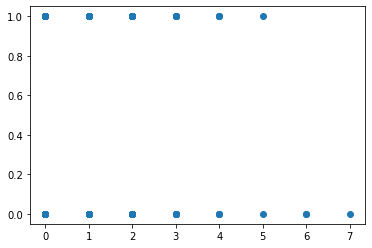

In [23]:
plt.scatter(df_train['Tax Liens'], target)



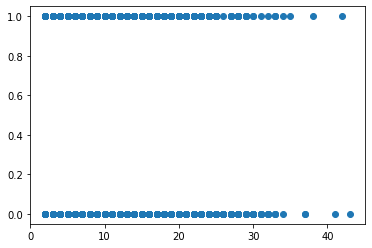

In [24]:
plt.scatter(df_train['Number of Open Accounts'], target)



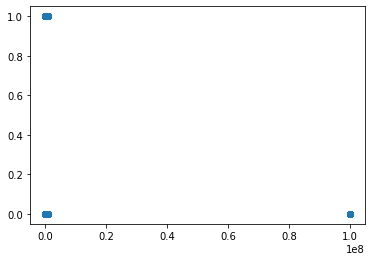

In [25]:
plt.scatter(df_train['Current Loan Amount'], target)



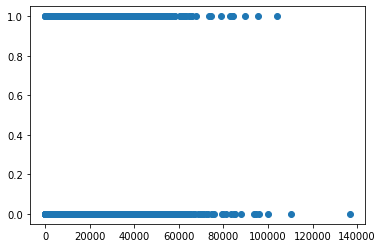

In [26]:
plt.scatter(df_train['Monthly Debt'], target)



In [27]:
current_loan = df_train['Current Loan Amount'].sort_values()
current_loan

1404       11242.0
4467       21472.0
2735       21472.0
7144       21516.0
5861       21560.0
           ...    
4384    99999999.0
732     99999999.0
4374    99999999.0
4555    99999999.0
0       99999999.0
Name: Current Loan Amount, Length: 7500, dtype: float64

In [28]:
#Здесь явно 870 выбросов со значениями 99999999.0 их можно изменить на средние
current_loan.value_counts()


99999999.0    870
89298.0         6
218064.0        6
222926.0        5
223322.0        5
             ... 
224444.0        1
570680.0        1
449746.0        1
132154.0        1
167904.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [29]:
df_train['Current Credit Balance'].sort_values(ascending=False).head(20)


4769    6506797.0
4745    4720132.0
4602    4367245.0
1580    4249673.0
7278    4209659.0
3316    3944514.0
2618    3927471.0
3198    3683340.0
162     3547262.0
1931    3271629.0
1233    2913707.0
2535    2889577.0
5974    2875726.0
837     2833451.0
4840    2784108.0
5823    2759617.0
1984    2759503.0
5432    2678088.0
604     2612177.0
2482    2611835.0
Name: Current Credit Balance, dtype: float64

In [30]:
df_train['Monthly Debt'].sort_values(ascending=False).head(20)

4745    136679.0
1615    110311.0
2535    104036.0
6946    100091.0
6253     96177.0
280      95508.0
166      94674.0
7478     93640.0
4439     89789.0
2502     87994.0
7459     85030.0
3601     84738.0
1472     84359.0
7179     83783.0
2064     83458.0
6727     83158.0
974      81346.0
6990     79661.0
5102     79555.0
6486     78925.0
Name: Monthly Debt, dtype: float64

In [31]:
df_train['Months since last delinquent'].sort_values(ascending=False).head(20)



4191    118.0
5214     92.0
5202     91.0
428      86.0
4682     84.0
1015     83.0
5546     83.0
5826     83.0
522      82.0
6174     82.0
7077     82.0
6761     82.0
6511     81.0
7100     81.0
6460     81.0
2337     81.0
2415     81.0
4199     81.0
4060     81.0
6121     81.0
Name: Months since last delinquent, dtype: float64

In [32]:
df_train['Credit Score'].sort_values(ascending=False).head(40)


2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
3063    7490.0
6055    7480.0
7282    7480.0
1531    7480.0
7355    7480.0
5899    7480.0
4436    7480.0
153     7470.0
263     7470.0
7460    7470.0
3638    7470.0
629     7460.0
5618    7460.0
4584    7460.0
4911    7460.0
5179    7460.0
2592    7460.0
3538    7460.0
2216    7460.0
3520    7450.0
534     7450.0
4037    7450.0
5353    7440.0
4491    7440.0
87      7440.0
5266    7440.0
3201    7440.0
267     7430.0
2883    7430.0
5045    7430.0
7016    7420.0
2519    7420.0
2571    7420.0
2777    7410.0
5730    7410.0
Name: Credit Score, dtype: float64

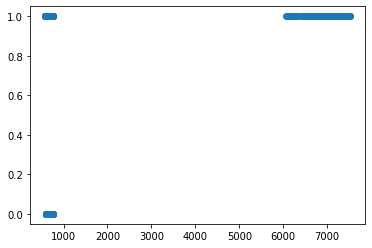

In [33]:
plt.scatter(df_train['Credit Score'], target)



In [34]:
credit_score = pd.DataFrame(df_train['Credit Score'])
credit_score[credit_score['Credit Score'] > 5000].value_counts()

Credit Score
7400.0          15
7300.0          13
7330.0          13
7170.0          12
7370.0          12
                ..
6750.0           1
6710.0           1
6680.0           1
6670.0           1
6060.0           1
Length: 110, dtype: int64

In [35]:
df_train[df_train['Credit Score'] > 5000]


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,249810.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,147950.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,143066.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,22176.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


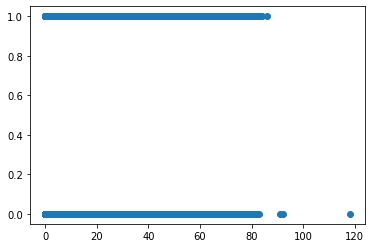

In [36]:
plt.scatter(df_train['Months since last delinquent'], target)


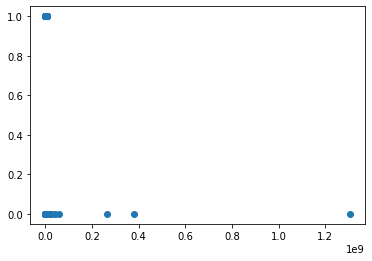

In [37]:
plt.scatter(df_train['Maximum Open Credit'], target)

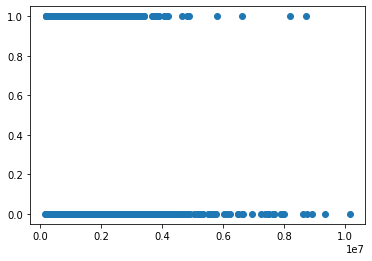

In [38]:
plt.scatter(df_train['Annual Income'], target)

In [39]:
df_train['Annual Income'].sort_values(ascending=False).head(40)

6472    10149344.0
2200     9338880.0
1025     8923844.0
1984     8758449.0
5396     8710740.0
2474     8633790.0
4491     8200229.0
1601     7999095.0
1616     7907382.0
2606     7883442.0
7097     7660648.0
5774     7655480.0
5102     7637240.0
3683     7514120.0
6604     7476880.0
3081     7381842.0
5108     7236606.0
4685     6961752.0
1615     6651900.0
7036     6620208.0
3446     6611810.0
3550     6495720.0
6946     6492395.0
3927     6222880.0
3269     6133922.0
4745     6029954.0
4271     5798040.0
7089     5759280.0
4445     5725194.0
3399     5712540.0
5934     5703648.0
602      5631030.0
4461     5628750.0
693      5605950.0
2468     5589420.0
2169     5584271.0
2992     5573460.0
5823     5493527.0
7486     5327372.0
7299     5289676.0
Name: Annual Income, dtype: float64

In [40]:
df_train['Maximum Open Credit'][df_train['Maximum Open Credit'] > 0].sort_values().head(40)


4425     4334.0
4365     6556.0
1513     6622.0
3041    10890.0
1050    10956.0
1747    11110.0
7184    11132.0
2195    11198.0
6338    12914.0
6649    17248.0
3271    17270.0
2241    17292.0
651     17314.0
4025    17644.0
1809    21670.0
7050    21780.0
6811    21978.0
5928    22000.0
2160    22044.0
7433    22176.0
367     25784.0
330     26070.0
1540    26752.0
1030    28996.0
5690    28996.0
5281    29238.0
5183    31108.0
4323    32670.0
5002    33242.0
523     33682.0
5617    34672.0
2086    37158.0
486     37268.0
57      37290.0
3830    37752.0
3063    38126.0
1803    38170.0
352     38764.0
3706    38962.0
4841    39072.0
Name: Maximum Open Credit, dtype: float64

In [41]:
df_train['Maximum Open Credit'].sort_values(ascending=False).head(40)



617     1.304726e+09
44      3.800523e+08
2617    2.655129e+08
2023    5.756256e+07
2763    4.092389e+07
7026    2.640700e+07
4769    2.634333e+07
5523    2.137243e+07
5731    1.928043e+07
3170    1.868381e+07
2468    1.634591e+07
354     1.476048e+07
4072    1.389707e+07
1879    1.270144e+07
4745    1.160386e+07
5950    1.151346e+07
1476    1.042866e+07
6744    1.030907e+07
4840    1.020160e+07
4602    9.541136e+06
5147    9.516540e+06
85      9.339924e+06
6265    9.167356e+06
2036    9.094184e+06
2431    8.947840e+06
5974    8.903180e+06
2156    8.706038e+06
5432    7.526552e+06
7278    7.453138e+06
1580    7.204516e+06
2375    6.890070e+06
4939    6.766276e+06
5313    6.658762e+06
4773    6.648488e+06
5618    6.639358e+06
3316    6.619316e+06
1601    6.286192e+06
561     6.230994e+06
7019    6.183782e+06
5818    6.148120e+06
Name: Maximum Open Credit, dtype: float64

In [42]:
# Значения которые больше 30 млн, сделаем равными 30 млн
df_train['Maximum Open Credit'][df_train['Maximum Open Credit'] > 30000000].sort_values()

2763    4.092389e+07
2023    5.756256e+07
2617    2.655129e+08
44      3.800523e+08
617     1.304726e+09
Name: Maximum Open Credit, dtype: float64

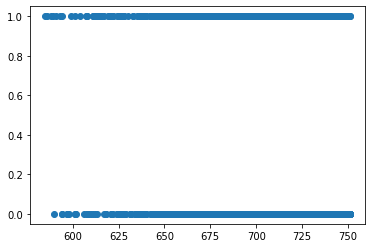

In [43]:
plt.scatter(df_train['Credit Score'][df_train['Credit Score'] < 5000], df_train['Credit Default'][df_train['Credit Score'] < 5000])

In [44]:
current_loan[current_loan < 99999999.0]


1404     11242.0
4467     21472.0
2735     21472.0
7144     21516.0
5861     21560.0
          ...   
359     788634.0
2420    788634.0
4602    788788.0
4700    788942.0
4960    789030.0
Name: Current Loan Amount, Length: 6630, dtype: float64

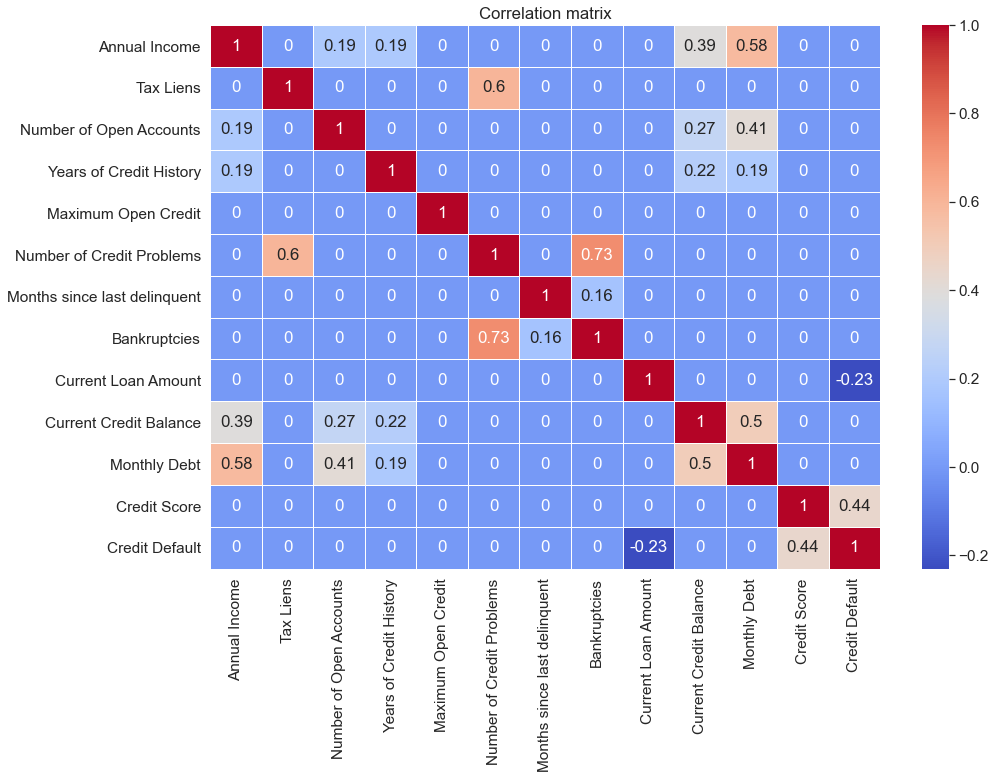

In [45]:
# Строим матрицу корреляций
def corr_matrix(df):
    plt.figure(figsize = (15,10))

    sns.set(font_scale=1.4)

    corr_matrix = df.corr()
    corr_matrix = np.round(corr_matrix, 2)
    corr_matrix[np.abs(corr_matrix) < 0.15] = 0

    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

    plt.title('Correlation matrix')

corr_matrix(df_train)



Text(0.5, 1.0, 'Correlation')

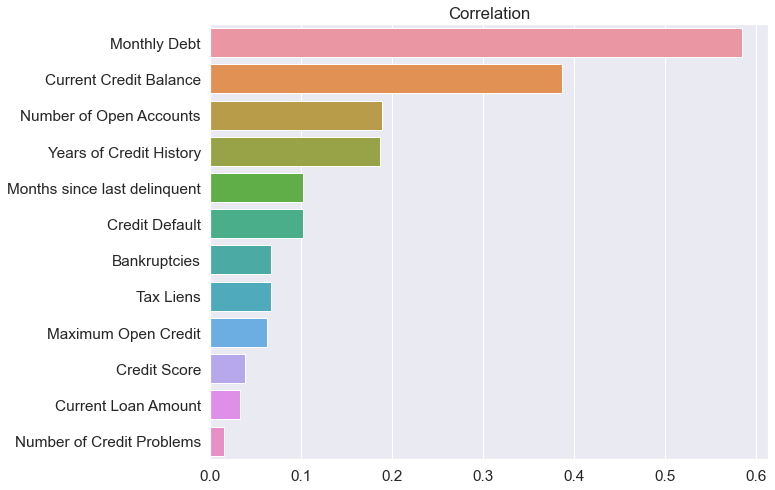

In [46]:
# смотрим, как коррелируют признаки с 'Annual Income'

FEATURE_NAMES = df_train.columns.drop('Annual Income').tolist()
corr_Annual_Income = df_train[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')

Выводы:<br/>
1) Current loan > 800000 заменяем на случайные значения<br/>
2) Maximum open credit > 30000000 ставим 30000000<br/>
3) У других признаков сильных выбросов не обнаружил, значения в пределах допустимых<br/>
4) Пропуски 'Credit Score' можно заполнить медианой<br/>
5) Пропуски Annual income заполняем по формуле (Annual Income  mean/ mouthly Debt mean)  * montly debt где annual income является пропуском<br/>
6) Пропуски Months since last delinquent и Years in current job заполняем нулями, т.к предполагается отстутствие этого параметра в местах пропуска<br/>
7) Пропуски Bankruptcies заполняем значением признака Number of Credit Problems<br/>
8) После обработки делаем новые признаки по выводам выше и на каждый выброс и пропуск ставлю признак-метку<br/>
9) Тестовый датасет и тренировочный дата сет обрабатываем одинаково, т.к признаки имеющие пропуски одни и те же<br/>


In [47]:
#Обработка пропусков
def fill_na(df):
    #Делаем новые признаки метки для пропусков
    df[['Annual Income_nan', 'Years in current job_nan', 'Months since last delinquent_nan', 'Credit Score_nan']] = 0
    #Делаем переменную коэффициент для умножения признака и заполнения пропуска
    corr_coef_mean = df_train['Annual Income'].mean()/df_train['Monthly Debt'].mean()
    #Заполняем Annual Income и делаем признак метку = 1
    df['Annual Income_nan'][df['Annual Income'].isna()] = 1
    df['Annual Income'][df['Annual Income'].isna()] = df['Monthly Debt'][df['Annual Income'].isna()] * corr_coef_mean
    #Заполняем Years in current job как не работающий и делаем признак метку = 1
    df['Years in current job_nan'][df['Years in current job'].isna()] = 1
    df['Years in current job'][df['Years in current job'].isna()] = "don't work"
    #Заполняем Months since last delinquent нулями и признак метку единицами
    df['Months since last delinquent_nan'][df['Months since last delinquent'].isna()] = 1
    df['Months since last delinquent'][df['Months since last delinquent'].isna()] = 0
    #Заполняем пропуски Bankruptcies delinquent
    df['Bankruptcies'][df['Bankruptcies'].isna()] = df['Number of Credit Problems'][df['Bankruptcies'].isna()]
    #Заполняем пропуски Credit Score медианой (пока) и признак метку = 1
    df['Credit Score_nan'][df['Credit Score'].isna()] = 1
    df['Credit Score'][df['Credit Score'].isna()] = df['Credit Score'].median()
    return df

df_train = fill_na(df_train)

In [48]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    7500 non-null   object 
 1   Annual Income                     7500 non-null   float64
 2   Years in current job              7500 non-null   object 
 3   Tax Liens                         7500 non-null   float64
 4   Number of Open Accounts           7500 non-null   float64
 5   Years of Credit History           7500 non-null   float64
 6   Maximum Open Credit               7500 non-null   float64
 7   Number of Credit Problems         7500 non-null   float64
 8   Months since last delinquent      7500 non-null   float64
 9   Bankruptcies                      7500 non-null   float64
 10  Purpose                           7500 non-null   object 
 11  Term                              7500 non-null   object 
 12  Curren

In [49]:
def fix_outliers(df):
    #Делаем признак метку для выбросов
    df[['Maximum Open Credit_outlier', 'Current Loan Amount_outlier']] = 0
    df['Maximum Open Credit_outlier'][df['Maximum Open Credit'] > 30000000] = 1
    df['Maximum Open Credit'][df['Maximum Open Credit'] > 30000000] = 30000000
    #loan_outliers = df['Current Loan Amount'][df['Current Loan Amount'] > 800000]
    df['Current Loan Amount_outlier'][df['Current Loan Amount'] > 800000] = 1
    #df['Current Loan Amount'][df['Current Loan Amount'] > 800000] = loan_outliers.apply(lambda  x: random.randint(0, 800000))
    return df
df_train = fix_outliers(df_train)

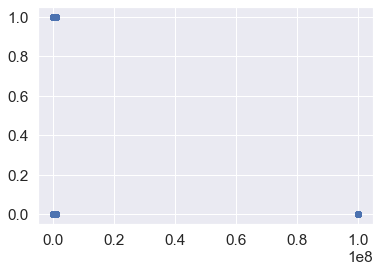

In [50]:
#Проверяем что выбросы устранил
plt.scatter(df_train['Current Loan Amount'], target)


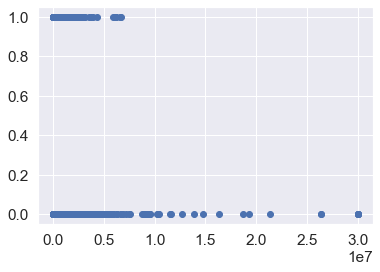

In [51]:
plt.scatter(df_train['Maximum Open Credit'], target)


In [52]:
#Делаем feature encoding а именно ранги категориальных признаков
#При необходимости базовые признаки от них можно потом удалить

def create_rank_cat(df):
    #Создаем и инциализируем новые признаки
    df[['Home Ownership_rank', 'Years in current job_rank', 'Tax Liens_rank', 'Number of Credit Problems_rank', 'Bankruptcies_rank', 'Term_rank', 'Purpose_rank', 'No problems']] = 0
    #Заполняем признак No problems
    df['No problems'][(df['Tax Liens'] == 0) & (df['Bankruptcies'] == 0) & (df['Number of Credit Problems'] == 0)] = 1
    #Исправляем ошибочное значение признака или однозначное в одно значение
    df['Home Ownership'][df['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'
    #Делаем ранги для домовладений
    df['Home Ownership_rank'][df['Home Ownership'] == 'Home Mortgage'] = 1
    df['Home Ownership_rank'][df['Home Ownership'] == 'Own Home'] = 2
    #Делаем ранги для времени работы
    df['Years in current job_rank'][df['Years in current job'].isin(['< 1 year'])] = 1
    df['Years in current job_rank'][df['Years in current job'].isin(['1 year', '2 years', '3 years'])] = 2
    df['Years in current job_rank'][df['Years in current job'].isin(['4 years', '5 years'])] = 3
    df['Years in current job_rank'][df['Years in current job'].isin(['6 years', '7 years', '8 years', '9 years', '10+ years'])] = 4
    #Делаем ранги для Tax Liens
    df['Tax Liens_rank'][df['Tax Liens'].isin([i for i in range(1, 4)])] = 1
    df['Tax Liens_rank'][df['Tax Liens'] == 0] = 2
    #Делаем ранги для Number of Credit Problems
    df['Number of Credit Problems_rank'][df['Number of Credit Problems'].isin([2, 3])] = 1
    df['Number of Credit Problems_rank'][df['Number of Credit Problems'] == 1] = 2
    df['Number of Credit Problems_rank'][df['Number of Credit Problems'] == 0] = 3
    #Заполняем ранг для банкротства
    df['Bankruptcies_rank'][df['Bankruptcies'] > 0] = 1
    #Заполняем ранг Term
    df['Term_rank'][df['Term'] == 'Long Term'] = 1
    #Заполняем ранг Purpose
    df['Purpose_rank'][df['Purpose'].isin(['buy house', 'buy a car', 'home improvements', 'medical bills'])] = 1
    df['Purpose_rank'][df['Purpose'].isin(['business loan', 'small business'])] = 2
    df['Purpose_rank'][df['Purpose'] == 'debt consolidation'] = 3
    df[['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']] = \
        df[['Tax Liens', 'Number of Credit Problems', 'Bankruptcies']].astype('int64')
    return df

df_train = create_rank_cat(df_train)

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Home Ownership                    7500 non-null   object 
 1   Annual Income                     7500 non-null   float64
 2   Years in current job              7500 non-null   object 
 3   Tax Liens                         7500 non-null   int64  
 4   Number of Open Accounts           7500 non-null   float64
 5   Years of Credit History           7500 non-null   float64
 6   Maximum Open Credit               7500 non-null   float64
 7   Number of Credit Problems         7500 non-null   int64  
 8   Months since last delinquent      7500 non-null   float64
 9   Bankruptcies                      7500 non-null   int64  
 10  Purpose                           7500 non-null   object 
 11  Term                              7500 non-null   object 
 12  Curren

Преобразовали датафрейм до нужного вида, теперь макисмум что можно сделать удалить базовые категориальные признаки<br/>
Пока этого не будем делать и оставим все как есть<br/>

Далее проверяем что все корректно отработало

In [54]:
df_train['Home Ownership_rank'].value_counts()

1    3649
0    3204
2     647
Name: Home Ownership_rank, dtype: int64

In [55]:
df_train['Home Ownership'].value_counts()



Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [56]:
df_train['Years in current job_rank'].value_counts()


4    3752
2    1829
3     985
1     563
0     371
Name: Years in current job_rank, dtype: int64

In [57]:
df_train['Years in current job'].value_counts()


10+ years     2332
2 years        705
3 years        620
< 1 year       563
5 years        516
1 year         504
4 years        469
6 years        426
7 years        396
don't work     371
8 years        339
9 years        259
Name: Years in current job, dtype: int64

In [58]:
df_train['Tax Liens_rank'].value_counts()


2    7366
1     123
0      11
Name: Tax Liens_rank, dtype: int64

In [59]:
df_train['Number of Credit Problems_rank'].value_counts()


3    6469
2     882
1     128
0      21
Name: Number of Credit Problems_rank, dtype: int64

In [60]:
df_train['Bankruptcies_rank'].value_counts()



0    6674
1     826
Name: Bankruptcies_rank, dtype: int64

In [61]:
df_train['Bankruptcies'].value_counts()



0    6674
1     786
2      31
3       7
4       2
Name: Bankruptcies, dtype: int64

In [62]:
df_train['Term_rank'].value_counts()



0    5556
1    1944
Name: Term_rank, dtype: int64

In [63]:
df_train['Purpose_rank'].value_counts()

3    5944
0     788
1     613
2     155
Name: Purpose_rank, dtype: int64

In [64]:
df_train['Purpose'].value_counts()



debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

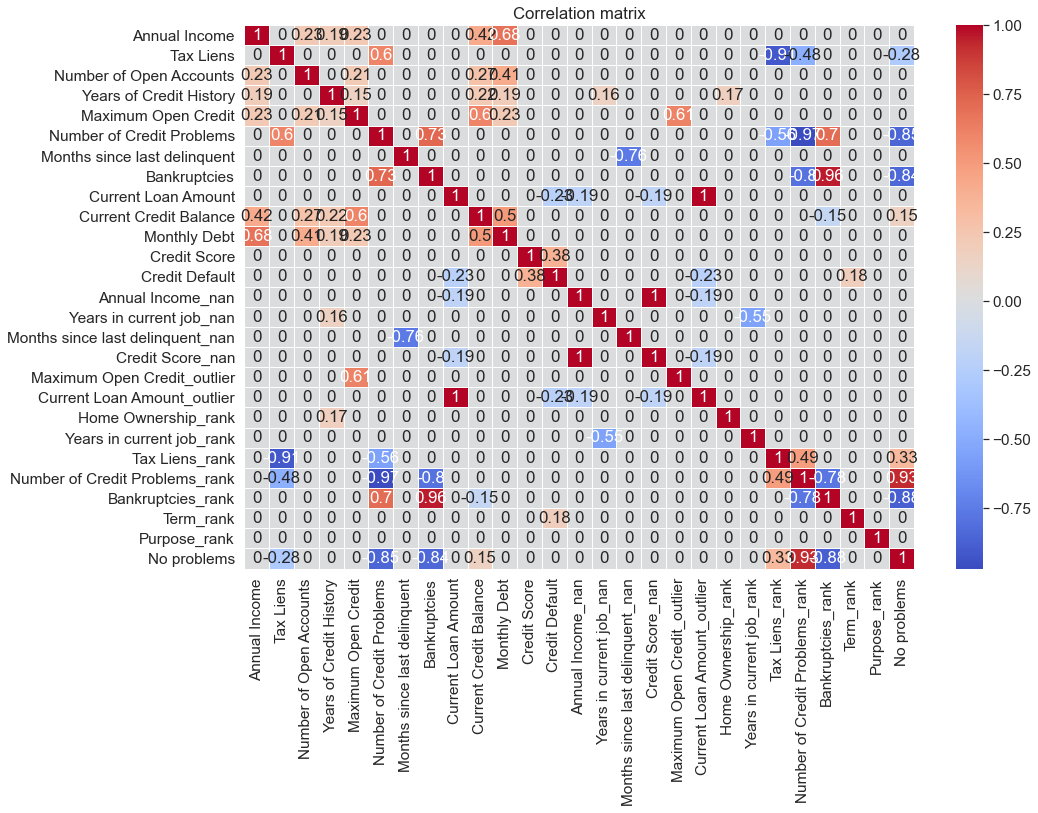

In [65]:
corr_matrix(df_train)

Ниже будем разбивать датасеты на тест и тренировочный<br/>
Делать балансировки целевых классов и обучать модели<br/>

In [66]:
#Делаем датаферйм без целевой переменной чтобы были одни признаки
df_features = df_train.drop('Credit Default', axis=1)
df_features

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Maximum Open Credit_outlier,Current Loan Amount_outlier,Home Ownership_rank,Years in current job_rank,Tax Liens_rank,Number of Credit Problems_rank,Bankruptcies_rank,Term_rank,Purpose_rank,No problems
0,Own Home,4.820870e+05,don't work,0,11.0,26.3,685960.0,1,0.0,1,...,0,1,2,0,2,2,1,0,3,0
1,Own Home,1.025487e+06,10+ years,0,15.0,15.3,1181730.0,0,0.0,0,...,0,0,2,4,2,3,0,1,3,1
2,Home Mortgage,7.514120e+05,8 years,0,11.0,35.0,1182434.0,0,0.0,0,...,0,1,1,4,2,3,0,0,3,1
3,Own Home,8.050680e+05,6 years,0,8.0,22.5,147400.0,1,0.0,1,...,0,0,2,4,2,2,1,0,3,0
4,Rent,7.762640e+05,8 years,0,13.0,13.6,385836.0,1,0.0,0,...,0,0,0,4,2,2,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,4.021920e+05,< 1 year,0,3.0,8.5,107866.0,0,0.0,0,...,0,0,0,1,2,3,0,0,0,1
7496,Home Mortgage,1.533984e+06,1 year,0,10.0,26.5,686312.0,0,43.0,0,...,0,0,1,2,2,3,0,1,3,1
7497,Rent,1.878910e+06,6 years,0,12.0,32.1,1778920.0,0,0.0,0,...,0,1,0,4,2,3,0,0,1,1
7498,Home Mortgage,2.769273e+06,don't work,0,21.0,26.5,1141250.0,0,0.0,0,...,0,0,1,0,2,3,0,0,3,1


In [67]:
#Тут делаем датафрейм только числовые признаки
Objects_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']
df_features_num = df_features.drop(Objects_features, axis=1)
df_features_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Annual Income                     7500 non-null   float64
 1   Tax Liens                         7500 non-null   int64  
 2   Number of Open Accounts           7500 non-null   float64
 3   Years of Credit History           7500 non-null   float64
 4   Maximum Open Credit               7500 non-null   float64
 5   Number of Credit Problems         7500 non-null   int64  
 6   Months since last delinquent      7500 non-null   float64
 7   Bankruptcies                      7500 non-null   int64  
 8   Current Loan Amount               7500 non-null   float64
 9   Current Credit Balance            7500 non-null   float64
 10  Monthly Debt                      7500 non-null   float64
 11  Credit Score                      7500 non-null   float64
 12  Annual

In [68]:
Numeric_cat = ['Current Loan Amount_outlier',
               'Tax Liens',
               'Number of Credit Problems',
               'Bankruptcies',
               'Annual Income_nan',
               'Years in current job_nan',
               'Months since last delinquent_nan',
               'Credit Score_nan',
               'Maximum Open Credit_outlier',
               'Home Ownership_rank',
               'Years in current job_rank',
               'Tax Liens_rank',
               'Number of Credit Problems_rank',
               'Bankruptcies_rank',
               'Term_rank',
               'Purpose_rank',
               'No problems']
Selected_features = ['Credit Score',
 'Current Loan Amount_outlier',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan Amount',
 'Current Credit Balance',
 'Years of Credit History',
 'Number of Open Accounts',
 'Home Ownership_rank',
 'Months since last delinquent',
 'Term_rank',
 'Purpose_rank',
 'Years in current job_rank',
 'Annual Income_nan',
 'Credit Score_nan',
 'Number of Credit Problems_rank',
 'Bankruptcies',
 'Number of Credit Problems',
 'Years in current job_nan',
 'Tax Liens_rank',
 'Tax Liens',
 'No problems',
 'Bankruptcies_rank',
 'Months since last delinquent_nan'
  ]


In [69]:
model = LGBMClassifier(is_unbalance=True, random_state=21)

rfe = RFE(estimator=model,
          n_features_to_select=20)

X_selected_RFE = rfe.fit_transform(df_train[Selected_features], target) # массив значений отобранных признаков
selected_features_RFE = df_train[Selected_features].columns[rfe.support_] # список отобранных признаков
# готовим таблицу с результатами
is_chosen = np.where(rfe.support_, '✅', '❌')
results = pd.DataFrame({'feature': Selected_features, 'rank': rfe.ranking_, 'is_chosen': is_chosen})
results = results.sort_values('rank', ascending=True)
results


,feature,rank,is_chosen
0,Credit Score,1,✅
20,Tax Liens_rank,1,✅
18,Number of Credit Problems,1,✅
17,Bankruptcies,1,✅
16,Number of Credit Problems_rank,1,✅
14,Annual Income_nan,1,✅
13,Years in current job_rank,1,✅
11,Term_rank,1,✅
10,Months since last delinquent,1,✅
12,Purpose_rank,1,✅


In [70]:
rfe_reatures = results['feature'][results['is_chosen'] == '✅']
rfe_reatures

0                         Credit Score
20                      Tax Liens_rank
18           Number of Credit Problems
17                        Bankruptcies
16      Number of Credit Problems_rank
14                   Annual Income_nan
13           Years in current job_rank
11                           Term_rank
10        Months since last delinquent
12                        Purpose_rank
8              Number of Open Accounts
7              Years of Credit History
6               Current Credit Balance
5                  Current Loan Amount
4                         Monthly Debt
3                  Maximum Open Credit
2                        Annual Income
1          Current Loan Amount_outlier
9                  Home Ownership_rank
24    Months since last delinquent_nan
Name: feature, dtype: object

In [71]:
X = df_train[rfe_reatures]
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.30,
                                                    random_state=21)

In [72]:
#Делаем функцию для балансировки данных
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)

    elif method == 'smote':
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [73]:
#Балансируем целевую переменную у датафрейма
#df_for_balancing = pd.concat([X_train, y_train], axis=1)
#df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')
#df_balanced['Credit Default'].value_counts()

In [74]:
#Разбиваем датафрейм еще раз
#X_train = df_balanced.drop('Credit Default', axis=1)
#y_train = df_balanced['Credit Default']


In [75]:
#Смотрим результат
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [76]:
frozen_params = {
      'class_weights':[1, 2.5],
      'silent':True,
      'random_state':21,
     'eval_metric':'F1',
      'early_stopping_rounds':20
}

cat_b = CatBoostClassifier(**frozen_params,
                            iterations=100,
                            max_depth=7,
                            reg_lambda=0.5)
cat_b.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [77]:
#Делаем метрики в читаемом виде
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def evaluate_preds(model, X_train, X_test, y_train, y_test):
     y_train_pred = model.predict(X_train)
     y_test_pred = model.predict(X_test)

     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

evaluate_preds(cat_b, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      3771
           1       0.49      0.60      0.54      1479

    accuracy                           0.71      5250
   macro avg       0.66      0.68      0.67      5250
weighted avg       0.74      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1616
           1       0.47      0.60      0.53       634

    accuracy                           0.70      2250
   macro avg       0.65      0.67      0.65      2250
weighted avg       0.72      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1193  423
1                256  378


In [78]:
cat_b = CatBoostClassifier(**frozen_params,
                                 iterations=100,
                                 max_depth=7)

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)
grid_search = cat_b.randomized_search({'reg_lambda': np.linspace(0.1, 4, 80)}, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)
grid_search
evaluate_preds(cat_b, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6555595799
bestIteration = 84

0:	loss: 0.6555596	best: 0.6555596 (0)	total: 706ms	remaining: 34.6s

bestTest = 0.6656859139
bestIteration = 91

1:	loss: 0.6656859	best: 0.6656859 (1)	total: 1.42s	remaining: 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6334841629
bestIteration = 6

2:	loss: 0.6334842	best: 0.6656859 (1)	total: 1.63s	remaining: 25.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6528956105
bestIteration = 78

3:	loss: 0.6528956	best: 0.6656859 (1)	total: 2.3s	remaining: 26.4s

bestTest = 0.6515373353
bestIteration = 98

4:	loss: 0.6515373	best: 0.6656859 (1)	total: 2.95s	remaining: 26.6s

bestTest = 0.6559179187
bestIteration = 93

5:	loss: 0.6559179	best: 0.6656859 (1)	total: 3.62s	remaining: 26.5s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6458797327
bestIteration = 47

6:	loss: 0.6458797	best: 0.6656859 (1)	total: 4.04s	remaining: 24.8s

bestTest = 0.6598614655
bestIteration = 97


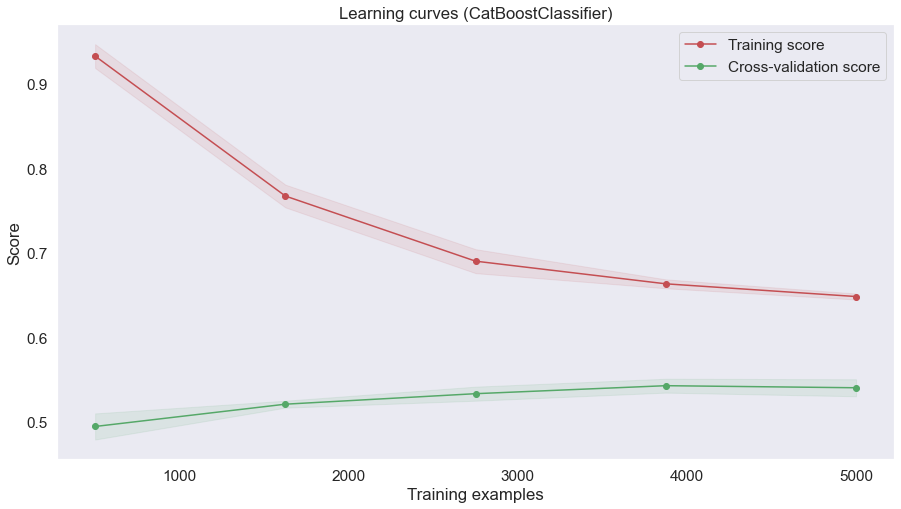

In [79]:
#Строим графики зависимости метрик
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

     #Determines cross-validated training and test scores for different training set sizes.
     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                             cv=cv,
                                                             scoring='f1',
                                                             train_sizes=train_sizes,
                                                             n_jobs=n_jobs)
     train_scores_mean = np.mean(train_scores, axis=1)
     train_scores_std = np.std(train_scores, axis=1)
     test_scores_mean = np.mean(test_scores, axis=1)
     test_scores_std = np.std(test_scores, axis=1)

     plt.figure(figsize=(15,8))
     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

     plt.title(f"Learning curves ({type(estimator).__name__})")
     plt.xlabel("Training examples")
     plt.ylabel("Score")
     plt.legend(loc="best")
     plt.grid()

show_learning_curve_plot(cat_b, X, y)

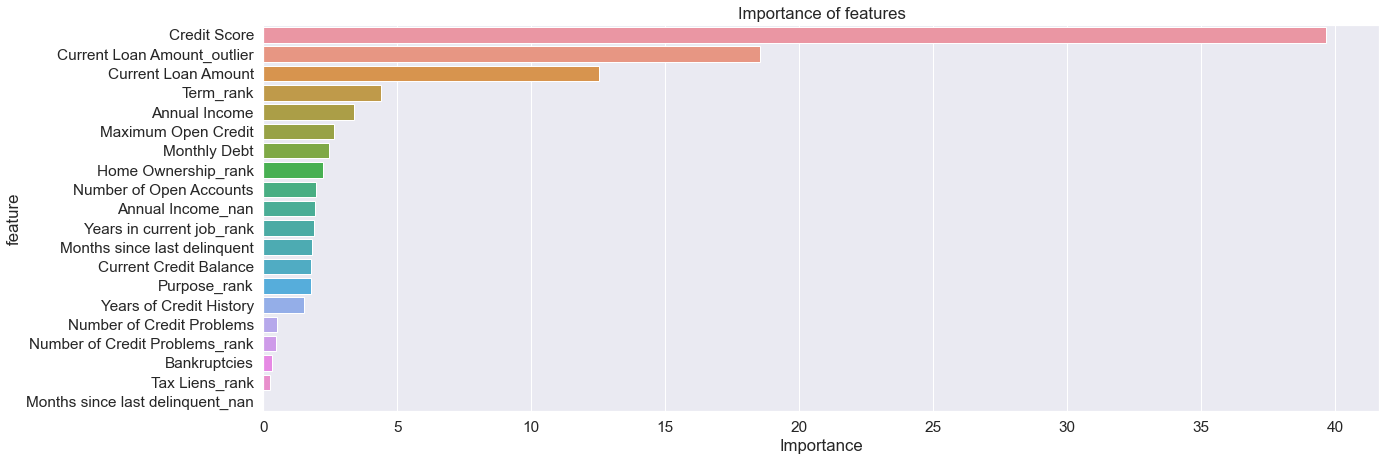

['Credit Score',
 'Current Loan Amount_outlier',
 'Current Loan Amount',
 'Term_rank',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Home Ownership_rank',
 'Number of Open Accounts',
 'Annual Income_nan',
 'Years in current job_rank',
 'Months since last delinquent',
 'Current Credit Balance',
 'Purpose_rank',
 'Years of Credit History',
 'Number of Credit Problems',
 'Number of Credit Problems_rank',
 'Bankruptcies',
 'Tax Liens_rank',
 'Months since last delinquent_nan']

In [80]:
#Смотрим самые важные признаки
def show_feature_importances(feature_names, feature_importances, get_top=None):
     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
     feature_importances = feature_importances.sort_values('importance', ascending=False)
     plt.figure(figsize = (20, len(feature_importances) * 0.355))
     sns.barplot(feature_importances['importance'], feature_importances['feature'])
     plt.xlabel('Importance')
     plt.title('Importance of features')
     plt.show()

     if get_top is not None:
         return feature_importances['feature'][:get_top].tolist()

important_features_top = show_feature_importances(X_train.columns, cat_b.feature_importances_, get_top=25)
important_features_top

In [81]:
frozen_params = {
      'class_weights':[1, 2.5],
      'silent':True,
      'random_state':21,
      'eval_metric':'F1',
      'early_stopping_rounds':20
}

cat_b_final = CatBoostClassifier(**frozen_params,
                                       iterations=100,
                                       max_depth=7,
                                       reg_lambda=0.5)

cat_b_final.fit(X_train[important_features_top], y_train)
evaluate_preds(cat_b_final, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      3771
           1       0.60      0.71      0.65      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.76      0.75      5250
weighted avg       0.80      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1616
           1       0.50      0.58      0.54       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.72      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1250  366
1                264  370


In [82]:
#Делаем сравнение показателей различных моделей
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    print(model, '  --  F1', f1_score(y_test, y_test_pred), '\nprecision', precision_score(y_test, y_test_pred), '\nrecall', recall_score(y_test, y_test_pred))


for model in [
#   Логистическая регрессия
    LogisticRegression(C = 0.1, class_weight = {0:1, 1:2.5}, penalty = 'l1', solver = 'liblinear', max_iter = 100),
    XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21),
    KNeighborsClassifier(), # К-ближайших соседей
    BaggingClassifier(), # Беггинг
    RandomForestClassifier(), # Случайный лес
#   Дерево решений
    DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:2.5}, max_depth=4),
    LGBMClassifier(class_weight={0:1, 1:2.5}, random_state=21),
    CatBoostClassifier(silent=True,random_state=21, class_weights=[1, 2.5], eval_metric='F1', early_stopping_rounds=20,
    custom_metric=['Precision', 'Recall'],
                                iterations=100,
                                max_depth=5,
                                min_data_in_leaf=5),
    AdaBoostClassifier(),
    SVC(C=0.05, kernel='rbf'), # Метод опорных векторов
    GaussianNB(),
    ExtraTreesClassifier(random_state=21, bootstrap=True, min_samples_split=0.3, class_weight={0:1, 1:2.5}),
    GradientBoostingClassifier(learning_rate=7, random_state=21), # Бустинг
    Perceptron(class_weight={0:1, 1:2.5})
]:
    pred_model(model)


LogisticRegression(C=0.1, class_weight={0: 1, 1: 2.5}, penalty='l1',
                   solver='liblinear')   --  F1 0.5354330708661417 
precision 0.4584269662921348 
recall 0.6435331230283912
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=50, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=21, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)   --  F1 0.47162426614481406 
precision 0.6211340206185567 
recall 0.3801261829652997
KNeighborsClassifier()   --  F1 0.27203065134099613 
precision 0.3463414634146341 
recall 0.22397476

In [83]:
#Обучаем Vote Classifier
vote = VotingClassifier(
    estimators=[('Extra Tree',ExtraTreesClassifier(random_state=21, bootstrap=True, min_samples_split=0.3, class_weight={0:1, 1:2.5})),
    ('CatBooster', CatBoostClassifier(silent=True,random_state=21, class_weights=[1, 2.5], eval_metric='F1', early_stopping_rounds=20,
    iterations=100, max_depth=5, min_data_in_leaf=5)),
    ('LGBMClassifier', LGBMClassifier(class_weight={0:1, 1:2.5}, random_state=21)),
    ('LogisticRegression', LogisticRegression(C=0.1, class_weight={0:1, 1:2.5}, max_iter=50, penalty='l1',
                   solver='liblinear')),
    ('DesisionTree', DecisionTreeClassifier(class_weight={0: 1, 1: 2.5}, max_depth=4, random_state=21))],
    voting='soft', weights=[1 ,1.5, 1.5, 1, 2.5], n_jobs=-1)

vote.fit(X_train, y_train)
y_train_pred = vote.predict(X_train)
y_test_pred = vote.predict(X_test)
f1_score(y_test, y_test_pred)

0.5345345345345346

In [84]:
precision_score(y_test, y_test_pred)



0.5100286532951289

In [85]:
recall_score(y_test, y_test_pred)



0.5615141955835962

In [86]:
evaluate_preds(cat_b, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.82      0.84      3771
           1       0.60      0.71      0.65      1479

    accuracy                           0.78      5250
   macro avg       0.74      0.76      0.75      5250
weighted avg       0.80      0.78      0.79      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1616
           1       0.50      0.59      0.54       634

    accuracy                           0.72      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1235  381
1                258  376


In [87]:
X_cb = pd.concat([df_train[Objects_features], df_train[rfe_reatures]], join="outer", axis=1)

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y,
                                                    shuffle=True,
                                                    test_size=0.30,
                                                    random_state=21)

numeric_cat_rfe= ['Current Loan Amount_outlier',
               #'Tax Liens',
               'Number of Credit Problems',
               'Bankruptcies',
               'Annual Income_nan',
               #'Years in current job_nan',
               'Months since last delinquent_nan',
               #'Credit Score_nan',
               #'Maximum Open Credit_outlier',
               'Home Ownership_rank',
               'Years in current job_rank',
               'Tax Liens_rank',
               #'Number of Credit Problems_rank',
               #'Bankruptcies_rank',
               #'Term_rank',
               'Purpose_rank']
               #'No problems']

In [88]:
#model_catb = CatBoostClassifier(n_estimators=100,
#                                     custom_loss=['F1'],
#                                     silent=True,
#                                     random_state=21)
#grid = {
#    'learning_rate': [0.05, 0.1, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],
#    'depth':[2, 4, 6, 7]
#}
#train_pool = Pool(data=X_train_cb, label=y_train_cb, cat_features=Objects_features+numeric_cat_rfe)
#test_pool = Pool(data=X_test_cb, label=y_test_cb, cat_features=Objects_features+numeric_cat_rfe)

#grid_search_results = model_catb.grid_search(grid, train_pool, cv=3, stratified=True,
#                                             verbose=False, plot=True)

In [89]:
#grid_search_results['params']

In [90]:
#Смотрим CatBoost


cat_b_final = CatBoostClassifier(silent=True, random_state=21, class_weights=[1, 2.5],
                    eval_metric='F1', early_stopping_rounds=20,
                    custom_metric=['Precision', 'Recall'],
                    use_best_model=True,
                    iterations=100,
                    max_depth=2,
#                    min_data_in_leaf=5,
                    learning_rate = 0.35)
cat_b_final.fit(X_train_cb, y_train_cb, eval_set=(X_test_cb, y_test_cb), cat_features=Objects_features+numeric_cat_rfe)

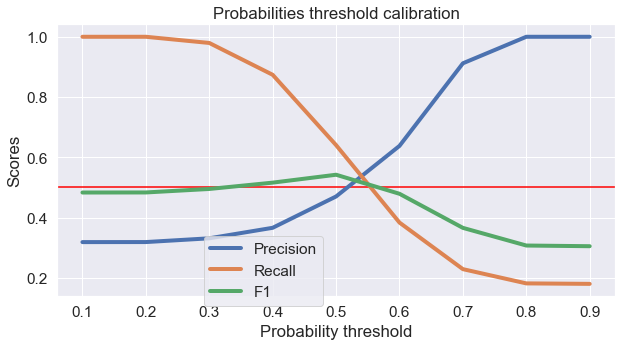

In [91]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25));

y_valid_proba = cat_b_final.predict_proba(X_test_cb)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_test_cb)

In [92]:
y_valid_pred = np.array(y_valid_proba > 0.53, dtype=int)
get_classification_report(y_train, y_train_pred, y_test_cb, y_valid_pred)
f1_score(y_test_cb, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      3771
           1       0.69      0.80      0.74      1479

    accuracy                           0.84      5250
   macro avg       0.80      0.83      0.82      5250
weighted avg       0.85      0.84      0.85      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1616
           1       0.52      0.55      0.53       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1293  323
1                287  347


0.5322085889570553

In [93]:
precision_score(y_test_cb, y_valid_pred)

0.517910447761194

In [94]:
recall_score(y_test_cb, y_valid_pred)

0.5473186119873817

In [95]:
y_train_pred_cb = cat_b_final.predict(X_train_cb)
y_test_pred_cb = cat_b_final.predict_proba(X_test_cb)[:, 1]
y_test_pred_cb = np.array(y_test_pred_cb > 0.53, dtype=int)
f1_score(y_test_cb, y_test_pred_cb)

0.5322085889570553

In [96]:
precision_score(y_test_cb, y_test_pred_cb)

0.517910447761194

In [97]:
recall_score(y_test_cb, y_test_pred_cb)

0.5473186119873817

In [98]:
evaluate_preds(cat_b_final, X_train_cb, X_test_cb, y_train_cb, y_test_cb)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      3771
           1       0.49      0.66      0.56      1479

    accuracy                           0.71      5250
   macro avg       0.66      0.69      0.67      5250
weighted avg       0.74      0.71      0.72      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.72      0.77      1616
           1       0.47      0.64      0.54       634

    accuracy                           0.70      2250
   macro avg       0.65      0.68      0.66      2250
weighted avg       0.73      0.70      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1158  458
1                228  406


In [99]:
#Смотрим Gradient Boost отдельно, самая сбалансированная модель
gradient_boost = GradientBoostingClassifier(learning_rate=7, random_state=21)
gradient_boost.fit(X_train, y_train)
y_train_pred = gradient_boost.predict(X_train)
y_test_pred = gradient_boost.predict(X_test)
f1_score(y_test, y_test_pred)

0.43779741672331746

In [100]:
precision_score(y_test, y_test_pred)



0.3847072879330944

In [101]:
recall_score(y_test, y_test_pred)


0.5078864353312302

Все модели обучены, самая сбалансированная Градиент и Vote ансамбли
Первое итоговое предсказание на vote сделаю

In [102]:
df_test = fill_na(df_test)
df_test = fix_outliers(df_test)
df_test = create_rank_cat(df_test)
#df_test["Credit Default"] = vote.predict(df_test[rfe_reatures])
Pred_porba_test = cat_b_final.predict_proba(df_test[X_test_cb.columns])[:, 1]
df_test["Credit Default"] = np.array(Pred_porba_test > 0.53, dtype=int)

df_test['ID'] = df_test.index.tolist()
df_test1 = df_test[['ID', 'Credit Default']]

#df_test1.to_csv('Nhalzev_predictions.csv', index=False)
df_test1.to_csv('Nhalzev_catboost_predictions.csv', index=False)

Конечные выводы по курсовой. 
CatBoost - очень сильный алгоритм, но он стремится либо к recall, либо к precision
Градиенты и Деревья более нейтральны, очень хорошо обучать на Vote деревьях и CatBoost
Для целевой метки все > 0.5 подходят ансамбли с деревьми и бустами
А так CatBoost подойдет)
P.S Можете проверить оба решения? И сравнить? Интересен результат 2мя способами

In [103]:
#fs = SelectKBest(score_func=f_classif, k=20)
#X_selected = fs.fit_transform(X, y) # массив значений отобранных признаков

#ind = list(fs.get_support(True)) # индексы отобранных признаков
#selected_features_kBest = [Selected_features[i] for i in ind] # список отобранных признаков
# готовим таблицу с результатами
#is_chosen = np.where(fs.get_support(), '✅', '❌')
#results = pd.DataFrame({'feature': Selected_features, 'pvalue': fs.pvalues_, 'is_chosen': is_chosen})
#results = results.sort_values('pvalue', ascending=True)
#results

In [104]:
#Kbest_reatures = results['feature'][results['is_chosen'] == '✅']
#Kbest_reatures



